In [1]:
import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ctypes

from scipy.sparse import lil_matrix
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import NearestNeighbors
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

from matplotlib import style
%matplotlib inline
style.use("fivethirtyeight")
sns.set_theme(style="whitegrid", color_codes=True)

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
# BeerAdvocate Dataset. arXiv:1210.3926 [cs.CL], arXiv:1303.4402 [cs.SI]. https://www.kaggle.com/datasets/rdoume/beerreviews.
df = pd.read_csv("/content/gdrive/MyDrive/Colab Datasets/beeradvocate5.csv")
df.columns = ["breweryid", "brewery_name", "rating_time", "rating_overall", "rating_smell", "rating_look", "userid", "beer_style", "rating_feel", "rating_taste", "beer_name", "beer_abv", "beerid"]
df = df[["userid", "beerid", "rating_overall", "rating_look", "rating_smell", "rating_taste", "rating_feel", "beer_name", "beer_style", "brewery_name", "beer_abv", "breweryid", "rating_time"]]

df["beer_abv"].fillna(df["beer_abv"].mean(), inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop(index=df[df["rating_overall"].isin([0.0])].index, inplace=True)
df["beer_full"] = df["beer_name"] + " (" + df["beer_style"] + ") by " + df["brewery_name"]
df.reset_index(drop=True, inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499883 entries, 0 to 499882
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   userid          499883 non-null  object 
 1   beerid          499883 non-null  int64  
 2   rating_overall  499883 non-null  float64
 3   rating_look     499883 non-null  float64
 4   rating_smell    499883 non-null  float64
 5   rating_taste    499883 non-null  float64
 6   rating_feel     499883 non-null  float64
 7   beer_name       499883 non-null  object 
 8   beer_style      499883 non-null  object 
 9   brewery_name    499883 non-null  object 
 10  beer_abv        499883 non-null  float64
 11  breweryid       499883 non-null  int64  
 12  rating_time     499883 non-null  int64  
 13  beer_full       499883 non-null  object 
dtypes: float64(6), int64(3), object(5)
memory usage: 53.4+ MB


In [4]:
df.head()

,userid,beerid,rating_overall,rating_look,rating_smell,rating_taste,rating_feel,beer_name,beer_style,brewery_name,beer_abv,breweryid,rating_time,beer_full
0,stcules,47986,1.5,2.5,2.0,1.5,1.5,Sausa Weizen,Hefeweizen,Vecchio Birraio,5.0,10325,1234817823,Sausa Weizen (Hefeweizen) by Vecchio Birraio
1,stcules,48213,3.0,3.0,2.5,3.0,3.0,Red Moon,English Strong Ale,Vecchio Birraio,6.2,10325,1235915097,Red Moon (English Strong Ale) by Vecchio Birraio
2,stcules,48215,3.0,3.0,2.5,3.0,3.0,Black Horse Black Beer,Foreign / Export Stout,Vecchio Birraio,6.5,10325,1235916604,Black Horse Black Beer (Foreign / Export Stout...
3,stcules,47969,3.0,3.5,3.0,3.0,2.5,Sausa Pils,German Pilsener,Vecchio Birraio,5.0,10325,1234725145,Sausa Pils (German Pilsener) by Vecchio Birraio
4,johnmichaelsen,64883,4.0,4.0,4.5,4.5,4.0,Cauldron DIPA,American Double / Imperial IPA,Caldera Brewing Company,7.7,1075,1293735206,Cauldron DIPA (American Double / Imperial IPA)...


In [5]:
df[["rating_overall", "rating_look", "rating_smell", "rating_taste", "rating_feel", "beer_abv"]].describe().T

,count,mean,std,min,25%,50%,75%,max
rating_overall,499883.0,3.827660,0.713019,1.00,3.5,4.0,4.5,5.0
rating_look,499883.0,3.858731,0.605573,1.00,3.5,4.0,4.0,5.0
rating_smell,499883.0,3.755603,0.689077,1.00,3.5,4.0,4.0,5.0
rating_taste,499883.0,3.812060,0.722387,1.00,3.5,4.0,4.5,5.0
rating_feel,499883.0,3.760862,0.671748,1.00,3.5,4.0,4.0,5.0
beer_abv,499883.0,7.075913,2.184723,0.01,5.4,6.7,8.5,57.7


<Axes: xlabel='rating_overall'>

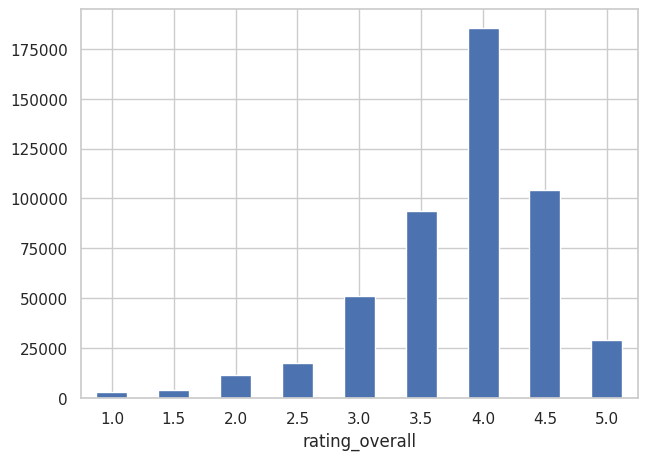

In [6]:
df["rating_overall"].value_counts().sort_index().plot(kind="bar", rot=0)

<Axes: >

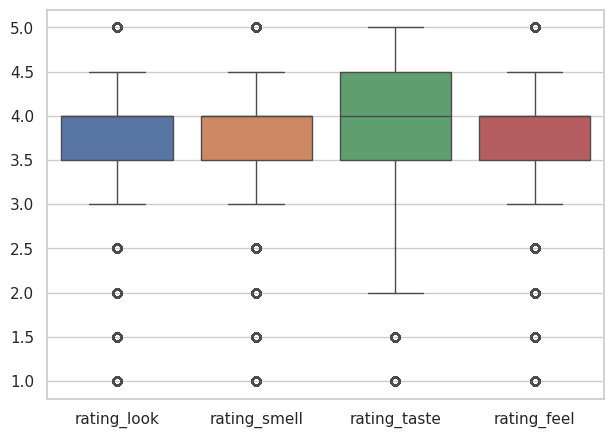

In [7]:
sns.boxplot(df[["rating_look", "rating_smell", "rating_taste", "rating_feel"]])

<Axes: xlabel='%ABV (Alcohol by volume)', ylabel='Frequency'>

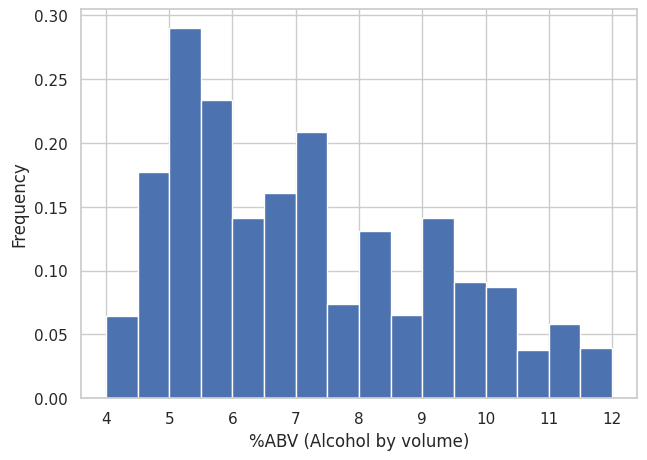

In [8]:
df["beer_abv"].plot(kind="hist", bins=16, range=[4, 12], density=True, xlabel="%ABV (Alcohol by volume)")

In [9]:
print("Most Popular Beers")
df.groupby("beer_full").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).sort_values("count", ascending=False).head(10)

Most Popular Beers


,mean,count
beer_full,,
Sierra Nevada Celebration Ale (American IPA) by Sierra Nevada Brewing Co.,4.168556,2999
Sierra Nevada Pale Ale (American Pale Ale (APA)) by Sierra Nevada Brewing Co.,4.245845,2587
Founders Breakfast Stout (American Double / Imperial Stout) by Founders Brewing Company,4.354658,2501
Sierra Nevada Bigfoot Barleywine Style Ale (American Barleywine) by Sierra Nevada Brewing Co.,3.966479,2491
La Fin Du Monde (Tripel) by Unibroue,4.298027,2483
Samuel Adams Boston Lager (Vienna Lager) by Boston Beer Company (Samuel Adams),4.044477,2417
Dead Guy Ale (Maibock / Helles Bock) by Rogue Ales,4.044579,2232
Trappistes Rochefort 10 (Quadrupel (Quad)) by Brasserie de Rochefort,4.339401,2170
Sierra Nevada Torpedo Extra IPA (American IPA) by Sierra Nevada Brewing Co.,4.104485,2029


In [10]:
print("Best Rated Beers")
df.groupby("beer_full").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).loc[lambda x: x["count"]>=100].sort_values("mean", ascending=False).head(10)

Best Rated Beers


,mean,count
beer_full,,
Citra DIPA (American Double / Imperial IPA) by Kern River Brewing Company,4.630952,252
Cantillon Blåbær Lambik (Lambic - Fruit) by Brasserie Cantillon,4.628205,156
Heady Topper (American Double / Imperial IPA) by The Alchemist,4.625800,469
Founders CBS Imperial Stout (American Double / Imperial Stout) by Founders Brewing Company,4.591052,637
Masala Mama India Pale Ale (American IPA) by Minneapolis Town Hall Brewery,4.488671,662
Unplugged Bohemian Lager (Czech Pilsener) by New Glarus Brewing Company,4.438849,139
Andechser Doppelbock Dunkel (Doppelbock) by Klosterbrauerei Andechs,4.432056,287
Czar Jack Imperial Stout (Russian Imperial Stout) by Minneapolis Town Hall Brewery,4.424370,119
Cantillon Lou Pepe - Gueuze (Gueuze) by Brasserie Cantillon,4.406250,128


In [11]:
print("Worst Rated Beers")
df.groupby("beer_full").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).loc[lambda x: x["count"]>=100].sort_values("mean").head(10)

Worst Rated Beers


,mean,count
beer_full,,
Brewer Patriot Collection - 1790 Root Beer Brew (Herbed / Spiced Beer) by Boston Beer Company (Samuel Adams),2.089286,196
Keystone Ice (American Adjunct Lager) by Coors Brewing Company,2.334532,139
Samuel Adams Triple Bock (American Strong Ale) by Boston Beer Company (Samuel Adams),2.358444,604
Coors Light (Light Lager) by Coors Brewing Company,2.576491,1157
Keystone Light (Light Lager) by Coors Brewing Company,2.585227,440
Molson XXX (American Malt Liquor) by Molson Coors Canada,2.610294,204
Heineken Premium Light Lager (Light Lager) by Heineken Nederland B.V.,2.628889,225
Colt 45 Malt Liquor (American Malt Liquor) by Pabst Brewing Company,2.666667,246
Hite (Euro Pale Lager) by Hite Brewery Company LTD,2.674312,109


In [12]:
print("Most Popular Beer Styles")
df.groupby("beer_style").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).sort_values("count", ascending=False).head(10)

Most Popular Beer Styles


,mean,count
beer_style,,
American IPA,3.993094,42427
American Double / Imperial IPA,3.951033,25803
American Double / Imperial Stout,4.101695,23069
American Pale Ale (APA),3.873079,20103
American Amber / Red Ale,3.855054,17641
American Porter,3.872726,16543
Russian Imperial Stout,4.011566,15563
Belgian Strong Dark Ale,4.011889,15266
Fruit / Vegetable Beer,3.534224,13587


In [13]:
print("Most Popular Breweries")
df.groupby("brewery_name").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).sort_values("count", ascending=False).head(10)

Most Popular Breweries


,mean,count
brewery_name,,
Boston Beer Company (Samuel Adams),3.689563,39438
Sierra Nevada Brewing Co.,4.056182,28746
Founders Brewing Company,4.114475,20000
Southern Tier Brewing Company,3.878049,15867
Great Divide Brewing Company,3.965506,14930
Rogue Ales,3.896553,14157
Unibroue,4.025548,13915
New Belgium Brewing,3.852950,13407
Weyerbacher Brewing Co.,3.773395,12246


In [14]:
rating, min_quality, min_quantity = "rating_overall", 3, 10
l1_reg, l2_reg = 0.001, 0.0001
threads = mp.cpu_count()
N = 10

df = df[["userid", "beerid", rating, "beer_full"]]
df = df[df[rating] >= min_quality]
df_temp = df["userid"].value_counts()
df = df[df["userid"].isin(df_temp[df_temp >= min_quantity].index)]
df_temp = df["beerid"].value_counts()
df = df[df["beerid"].isin(df_temp[df_temp >= min_quantity].index)]
df.reset_index(drop=True, inplace=True)
U, T = np.sort(df["userid"].unique()), np.sort(df["beerid"].unique())
m, n = len(U), len(T)
df["userid"] = df["userid"].map({userid: index for index, userid in enumerate(U)})
df["beerid"] = df["beerid"].map({beerid: index for index, beerid in enumerate(T)})

model = ElasticNet(alpha=l1_reg+l2_reg,
                   l1_ratio=l1_reg/(l1_reg+l2_reg),
                   positive=True, fit_intercept=False, copy_X=False, random_state=42)
model_knn = NearestNeighbors(n_neighbors=int(n/10))

In [15]:
def get_train_test(df):
    test = df.groupby("userid", group_keys=False).apply(lambda grp: grp.sample(n=1, random_state=42))
    train = df.drop(test.index)
    return train, test

In [16]:
def get_A(train):
    A = lil_matrix((m, n))
    for row in zip(train["userid"], train["beerid"], train[rating]):
        A[row[0], row[1]] = row[2]
    return A

In [17]:
def get_A_hat(A):
    m, n = A.shape
    W = lil_matrix((n, n))
    for j in range(n):
        a_j = A[:, j].copy()
        A[:, j] = 0
        model.fit(A, a_j.toarray())
        A[:, j] = a_j
        w_j = model.coef_
        w_j[w_j < 0] = 0
        for index in w_j.nonzero()[0]:
            W[(index, j)] = w_j[index]
    return (A @ W).tolil()

In [18]:
def get_A_hat_fs(A):
    m, n = A.shape
    A_csc = A.tocsc(copy=True)
    model_knn.fit(A.transpose(copy=True))
    nn = model_knn.kneighbors(return_distance=False)
    W = lil_matrix((n, n))
    for j in range(n):
        a_j = A[:, j].copy()
        model.fit(A_csc[:, nn[j]], a_j.toarray())
        w_j = model.coef_
        w_j[w_j < 0] = 0
        for index in w_j.nonzero()[0]:
            W[(index, j)] = w_j[index]
    return (A @ W).tolil()

In [19]:
def parallel(params):
    A = params[2]
    for j in range(params[0], params[1]):
        a_j = A[:, j].copy()
        A[:, j] = 0
        model.fit(A, a_j.toarray())
        A[:, j] = a_j
        w_j = model.coef_
        w_j[w_j < 0] = 0
        for index in w_j.nonzero()[0]:
            W_[(index, j)] = w_j[index]

def get_A_hat_parallel(A):
    m, n = A.shape
    global W_
    W_ = np.ctypeslib.as_array(
        mp.Array(ctypes.c_double, n*n).get_obj()
        ).reshape(n, n)
    n_ = math.ceil(n/threads)
    params = []
    for i in range(threads-1):
        params.append([i*n_, (i+1)*n_, A])
    params.append([(i+1)*n_, n, A])
    with ProcessPoolExecutor() as executor:
        executor.map(parallel, params)
    return lil_matrix(A @ W_)

In [21]:
def get_recs(A_hat, A):
    m, n = A_hat.shape
    recs = []
    for i in range(m):
        recs.append([])
        for j in A_hat[i].nonzero()[1]:
            if (A[(i, j)] == 0):
                recs[-1].append((j, A_hat[(i, j)]))
        recs[-1].sort(key=lambda x: x[1], reverse=True)
        recs[-1] = [pair[0] for pair in recs[-1][:N]]
    return recs

In [22]:
def display_user_recs(df, recs, userid):
    print(f"Top {N} Beer Recommendations for User#{userid}\n")
    for rec in recs[userid]:
        print(df[df["beerid"] == rec]["beer_full"].tolist()[0])

In [23]:
def get_HR_ARHR(recs, test):
    test.reset_index(drop=True, inplace=True)
    HR, ARHR = 0, 0
    for i in range(m):
        try:
            p = recs[i].index(test["beerid"][i]) + 1
            HR += 1
            ARHR += (1 / p)
        except ValueError:
            continue
    return (HR/m, ARHR/m)

In [24]:
# train, test = get_train_test(df)
# A = get_A(train)
# A_hat = get_A_hat(A)
# recs = get_recs(A_hat, A)
# HR, ARHR = get_HR_ARHR(recs, test)
# print(f"Hit Rate (HR): {HR}\nAverage Reciprocal Hit-Rank (ARHR): {ARHR}")

In [25]:
train, test = get_train_test(df)
A = get_A(train)

In [26]:
get_HR_ARHR(get_recs(get_A_hat(A), A), test)
# 474 secs

(0.21567978828977838, 0.09366674280253509)

In [27]:
get_HR_ARHR(get_recs(get_A_hat_fs(A), A), test)
# 467 secs

(0.015216672179953688, 0.00527221198326061)

In [28]:
get_HR_ARHR(get_recs(get_A_hat_parallel(A), A), test)
# 338 secs

(0.21567978828977838, 0.09366674280253509)